# Knowledge Extraction

This notebook demonstrates a fine-grained knowledge extraction pipeline to translate complex relations learned within a deep neural network into human-readable rules and insights.

## Packages

In [1]:
import sys
sys.path.append(r"h:\Resume\Projects\DataScience\Banking Telemarketing Decision Support System\Project")


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_ingestion import load_csv_to_dataframe

from src.models.model_repository import ModelRepository
from configs.config_repository import ConfigRepository

from src.data_preprocessing import process_dataset

from src.models.model_utils import evaluate_model_on_test

from src.knowledge_extraction import REMDExtractor

## Load the data

In [2]:
df_train = load_csv_to_dataframe(file_path = '../data//raw/bank-full.csv')
df_test = load_csv_to_dataframe(file_path = '../data/raw/bank.csv' )

Dataset loaded successfully with 45211 rows and 17 columns.
Dataset loaded successfully with 4521 rows and 17 columns.


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [139]:
df_test['month'].head()

0    oct
1    may
2    apr
3    jun
4    may
Name: month, dtype: object

## Load the pretrained Multi layer preceptron model 

In [4]:
model_repo = ModelRepository()

model_repo.list_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1745958323864, description=None, last_updated_timestamp=1745958323923, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1745958323923, current_stage='None', description=None, last_updated_timestamp=1745958323923, name='BankMarketing_DT', run_id='efc55130af2f4605af0efafe8673394c', run_link=None, source=('file:///h:/Resume/Projects/DataScience/Banking Telemarketing Decision '
  'Support '
  'System/Project/notebooks/../src/models/mlruns/428291184944362037/efc55130af2f4605af0efafe8673394c/artifacts/Decision_Tree_model'), status='READY', status_message=None, tags={}, user_id=None, version=1>], name='BankMarketing_DT', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1745954512323, description=None, last_updated_timestamp=1745954512357, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1745954512357, current_stage='None', description=None, last_updated_timestamp=1745954512357, name='BankMarketing_LogReg'

In [5]:
mlp_pretrain = model_repo.load_model(registered_name='MLP')

In [6]:
print(mlp_pretrain)

<Sequential name=sequential_1, built=True>


## Data Preprocessing

load configs

In [7]:
cr = ConfigRepository(config_path="../configs/models_config.json")
fe_config = cr.get_config("fe_config")

In [16]:
data_train_prep = process_dataset(
    df_=df_train,
    target_column='y',
    missing_method='drop',  # or 'fill'
    fill_value=None,
    fill_method=None,
    missing_threshold=0.5,
    outlier_removal=False,
    add_new_features=True,
    fe_config=fe_config,
    return_dataframe=True,
)

data_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44709 entries, 0 to 44708
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__balance                   44709 non-null  float64
 1   num__day                       44709 non-null  float64
 2   num__duration                  44709 non-null  float64
 3   num__campaign                  44709 non-null  float64
 4   cat__job_admin.                44709 non-null  float64
 5   cat__job_blue-collar           44709 non-null  float64
 6   cat__job_entrepreneur          44709 non-null  float64
 7   cat__job_housemaid             44709 non-null  float64
 8   cat__job_management            44709 non-null  float64
 9   cat__job_retired               44709 non-null  float64
 10  cat__job_self-employed         44709 non-null  float64
 11  cat__job_services              44709 non-null  float64
 12  cat__job_student               44709 non-null 

In [17]:
X_train = data_train_prep.drop(columns = ['y'])

y_train = data_train_prep['y']

In [8]:
data_test_prep = process_dataset(
    df_=df_test,
    target_column='y',
    missing_method='drop',  # or 'fill'
    fill_value=None,
    fill_method=None,
    missing_threshold=0.5,
    outlier_removal=False,
    add_new_features=True,
    fe_config=fe_config,
    return_dataframe=True,
)

data_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__balance                   4461 non-null   float64
 1   num__day                       4461 non-null   float64
 2   num__duration                  4461 non-null   float64
 3   num__campaign                  4461 non-null   float64
 4   cat__job_admin.                4461 non-null   float64
 5   cat__job_blue-collar           4461 non-null   float64
 6   cat__job_entrepreneur          4461 non-null   float64
 7   cat__job_housemaid             4461 non-null   float64
 8   cat__job_management            4461 non-null   float64
 9   cat__job_retired               4461 non-null   float64
 10  cat__job_self-employed         4461 non-null   float64
 11  cat__job_services              4461 non-null   float64
 12  cat__job_student               4461 non-null   f

In [9]:
X_test = data_test_prep.drop(columns = ['y'])

y_test = data_test_prep['y']

## Re-evaluation of the model

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
y_test_proba: (4461,)


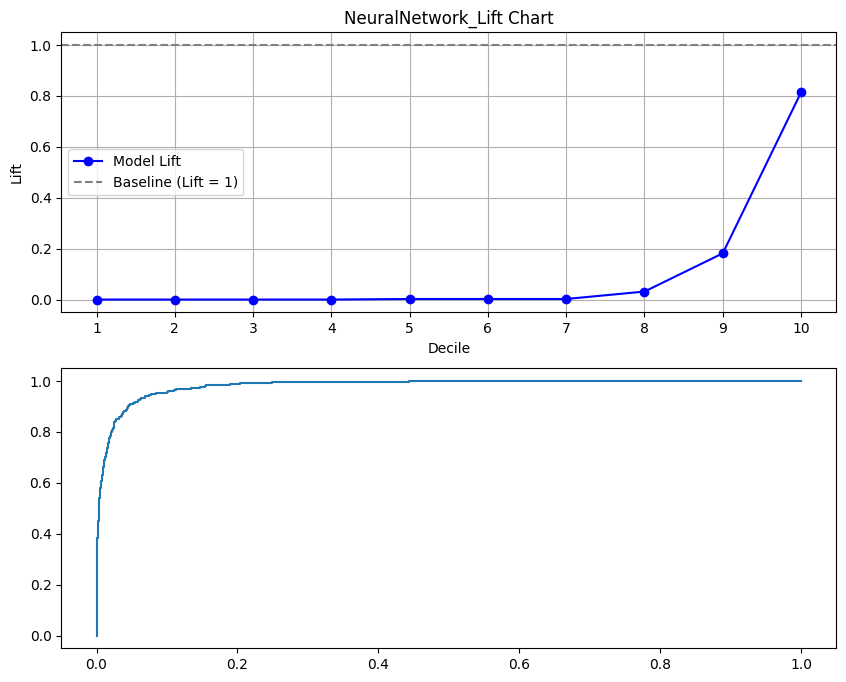

In [10]:
fig_, axes_   = plt.subplots(2, 1, figsize=(10, 8))
axes = axes_.ravel()
test_auc_val, alift = evaluate_model_on_test(estimator=mlp_pretrain, estimator_name="NeuralNetwork", 
                       X_test=X_test, y_test=y_test, ax_lift=axes[0], ax_roc=axes[1])

In [11]:
print("=== Test set performance summary ===")

print(f"Test AUC: {test_auc_val:.3f}, ALIFT: {alift:.3f}")

=== Test set performance summary ===
Test AUC: 0.982, ALIFT: 0.103


## Knowledge Extraction

In [120]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.tree import DecisionTreeClassifier, _tree

class REMDExtractor:
    def __init__(self, model, feature_names, max_depth=4, input_dim=None, threshold=0.5):
        """
        model: tf.keras Sequential or Functional
        feature_names: list of input feature names
        max_depth: max depth for trees
        input_dim: number of features if model.input undefined
        threshold: cutoff for binary preds
        """
        self.model = model
        self.feature_names = feature_names
        self.max_depth = max_depth
        self.threshold = threshold

        # Determine input_dim
        if input_dim is None:
            try:
                input_dim = model.layers[0].input_shape[1]
            except Exception:
                raise ValueError("Provide input_dim when model.input is undefined.")
        self.input_dim = input_dim

        # Build extraction sub-model with explicit Input
        inp = Input(shape=(self.input_dim,), name='extraction_input')
        x = inp
        hidden_outputs = []
        for idx, layer in enumerate(self.model.layers):
            x = layer(x)
            # capture hidden Dense layers (exclude final layer)
            if isinstance(layer, Dense) and idx < len(self.model.layers) - 1:
                hidden_outputs.append(x)
        self.activation_model = Model(inputs=inp, outputs=hidden_outputs)

    def get_activations(self, X):
        """Return activations for each hidden layer."""
        return self.activation_model.predict(X, verbose=0)

    def binarize_preds(self, X):
        """Convert single-output model probabilities to binary labels."""
        probs = self.model.predict(X, verbose=0).reshape(-1)
        return (probs >= self.threshold).astype(int)

    def extract_tree_rules(self, tree, feature_labels):
        """Traverse a decision tree to extract IF–THEN rules."""
        tree_ = tree.tree_
        rules = []

        def recurse(node, conds):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                idx = tree_.feature[node]
                # Safely get feature name
                try:
                    name = feature_labels[idx]
                except IndexError:
                    name = f"feature_{idx}"
                thr = tree_.threshold[node]
                recurse(tree_.children_left[node], conds + [(name, '<=', thr)])
                recurse(tree_.children_right[node], conds + [(name, '>', thr)])
            else:
                val = np.argmax(tree_.value[node])
                rules.append((conds, val))

        recurse(0, [])
        text_rules = []
        for conds, val in rules:
            antecedent = ' & '.join(f"{n} {op} {thr:.4f}" for n, op, thr in conds)
            text_rules.append({'if': antecedent, 'then': int(val)})
        return text_rules

    def train_tree(self, activations, targets):
        """Train a decision tree on activations and binary targets."""
        dt = DecisionTreeClassifier(max_depth=self.max_depth)
        dt.fit(activations, targets)
        return dt

    def substitute_rules(self, tree, preds, layer_idx):
        """Extract rules from one layer's tree and update preds."""
        # Align feature labels to tree input dimension
        n_feats = tree.n_features_in_
        labels = [f"h{layer_idx}_n{i}" for i in range(n_feats)]
        # Extract and keep only positive-class rules
        rules = [r for r in self.extract_tree_rules(tree, labels) if r['then'] == 1]
        # Update preds based on this tree
        new_preds = tree.predict(self.current_activations[layer_idx])
        return new_preds, rules

    def translate_to_input(self, X, preds):
        """Train a final tree on original inputs to map preds to input features."""
        tree = self.train_tree(X, preds)
        # Use sklearn's feature_names_in_ if available
        try:
            feature_labels = list(tree.feature_names_in_)
        except AttributeError:
            feature_labels = self.feature_names
        # Extract rules and keep only positive-class ones
        rules = self.extract_tree_rules(tree, feature_labels)
        return [r for r in rules if r['then'] == 1]

    def extract(self, X):
        """Full REM-D pipeline: predict → activations → backward extraction → input translation."""
        # Initial binary predictions
        preds = self.binarize_preds(X)
        # Hidden-layer activations
        activations = self.get_activations(X)
        self.current_activations = activations
        rules = []
        # Backward pass through hidden layers
        for i in reversed(range(len(activations))):
            tree = self.train_tree(activations[i], preds)
            preds, rules = self.substitute_rules(tree, preds, layer_idx=i)
        # Final translation to input-level rules
        return self.translate_to_input(X, preds)



In [121]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [122]:
feature_names = df_test.columns.tolist()
feature_names.remove('y')

In [123]:
feature_names

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [135]:
extractor = REMDExtractor(
    model=mlp_pretrain,
    feature_names=feature_names,
    max_depth=6,
    input_dim=X_test.shape[1]  # only needed if mlp.input is undefined
)

In [136]:
rules = extractor.extract(X_train)

In [137]:

for r in rules:
    print(f"IF {r['if']} THEN class={r['then']}")

IF cat__poutcome_success <= 0.5000 & num__duration <= 3.5144 & num__duration > 1.5899 & cat__poutcome_unknown <= 0.5000 & cat__education_tertiary > 0.5000 & num__day <= -0.2777 THEN class=1
IF cat__poutcome_success <= 0.5000 & num__duration > 3.5144 & cat__education_tertiary <= 0.5000 & num__duration <= 6.7509 & cat__previous_category_0 <= 0.5000 & num__balance > -0.1825 THEN class=1
IF cat__poutcome_success <= 0.5000 & num__duration > 3.5144 & cat__education_tertiary <= 0.5000 & num__duration > 6.7509 & cat__marital_married <= 0.5000 & cat__month_jan <= 0.5000 THEN class=1
IF cat__poutcome_success <= 0.5000 & num__duration > 3.5144 & cat__education_tertiary <= 0.5000 & num__duration > 6.7509 & cat__marital_married > 0.5000 & num__duration > 9.5819 THEN class=1
IF cat__poutcome_success <= 0.5000 & num__duration > 3.5144 & cat__education_tertiary > 0.5000 & num__duration <= 4.1108 & cat__marital_single <= 0.5000 & num__duration <= 3.5581 THEN class=1
IF cat__poutcome_success <= 0.5000 &

In [140]:
# TODO: Remove month and campaign features from the data
# TODO: Integrate the preprocessing step with the model